In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

3


In [2]:
import diffimTests as dit
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.
n_sources = 100
n_varSources = 50
seed = 66

Get a handle on SNR vs. input flux. Let's see...

In [3]:
reload(dit)

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                         offset=[0,0], psf_yvary_factor=0., sourceFluxDistrib='uniform',
                         varFlux2=np.repeat(500., n_varSources), variablesNearCenter=False,
                         theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                         sourceFluxRange=(500,30000), avoidBorder=False, 
                         seed=seed, psfSize=21)

res = testObj.runTest()
print res

{'ZOGY': {'FP': 1, 'FN': 48, 'TP': 2}, 'ALstack': {'FP': 1, 'FN': 50, 'TP': 0}, 'SZOGY': {'FP': 1, 'FN': 48, 'TP': 2}, 'ALstack_noDecorr': {'FP': 1, 'FN': 48, 'TP': 2}}


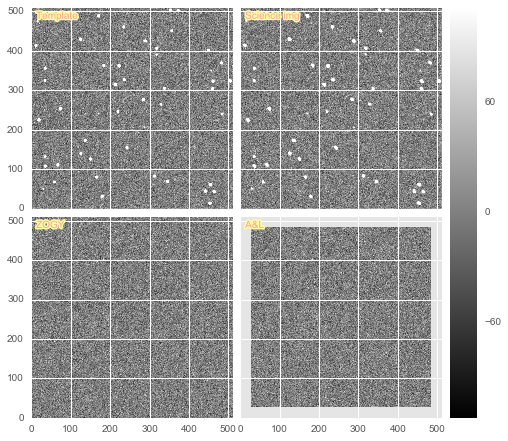

In [4]:
reload(dit)
fig = plt.figure(1, (8, 8))
testObj.doPlot()

In [5]:
reload(dit)
src1 = testObj.im1.doDetection(threshold=5.0)
src2 = testObj.im2.doDetection(threshold=5.0)

src1 = src1[~src1['base_PsfFlux_flag']]
src2 = src2[~src2['base_PsfFlux_flag']]

print src1.shape
print src2.shape

(42, 140)
(47, 140)


In [6]:
src = src1
dist = np.sqrt(np.add.outer(src.base_NaiveCentroid_x, -testObj.centroids[:, 0])**2. + \
   np.add.outer(src.base_NaiveCentroid_y, -testObj.centroids[:, 1])**2.) # in pixels
matches = np.where(dist <= 1.5)
true_pos = len(np.unique(matches[0]))
false_neg = testObj.centroids.shape[0] - len(np.unique(matches[1]))
false_pos = src.shape[0] - len(np.unique(matches[0]))
detections = {'TP': true_pos, 'FN': false_neg, 'FP': false_pos}
print detections

src_hits1 = src.iloc[matches[0],:]
input_hits1 = testObj.centroids[matches[1],:]

{'FP': 0, 'FN': 58, 'TP': 42}


In [7]:
sizeme(src_hits1.head())

,base_CircularApertureFlux_12_0_flag,base_CircularApertureFlux_12_0_flag_apertureTruncated,base_CircularApertureFlux_12_0_flux,base_CircularApertureFlux_12_0_fluxSigma,base_CircularApertureFlux_17_0_flag,base_CircularApertureFlux_17_0_flag_apertureTruncated,base_CircularApertureFlux_17_0_flux,base_CircularApertureFlux_17_0_fluxSigma,base_CircularApertureFlux_25_0_flag,base_CircularApertureFlux_25_0_flag_apertureTruncated,base_CircularApertureFlux_25_0_flux,base_CircularApertureFlux_25_0_fluxSigma,base_CircularApertureFlux_35_0_flag,base_CircularApertureFlux_35_0_flag_apertureTruncated,base_CircularApertureFlux_35_0_flux,base_CircularApertureFlux_35_0_fluxSigma,base_CircularApertureFlux_3_0_flag,base_CircularApertureFlux_3_0_flag_apertureTruncated,base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_3_0_flux,base_CircularApertureFlux_3_0_fluxSigma,base_CircularApertureFlux_4_5_flag,base_CircularApertureFlux_4_5_flag_apertureTruncated,base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,base_CircularApertureFlux_4_5_flux,base_CircularApertureFlux_4_5_fluxSigma,base_CircularApertureFlux_50_0_flag,base_CircularApertureFlux_50_0_flag_apertureTruncated,base_CircularApertureFlux_50_0_flux,base_CircularApertureFlux_50_0_fluxSigma,base_CircularApertureFlux_6_0_flag,base_CircularApertureFlux_6_0_flag_apertureTruncated,base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_6_0_flux,base_CircularApertureFlux_6_0_fluxSigma,base_CircularApertureFlux_70_0_flag,base_CircularApertureFlux_70_0_flag_apertureTruncated,base_CircularApertureFlux_70_0_flux,base_CircularApertureFlux_70_0_fluxSigma,base_CircularApertureFlux_9_0_flag,base_CircularApertureFlux_9_0_flag_apertureTruncated,base_CircularApertureFlux_9_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_9_0_flux,base_CircularApertureFlux_9_0_fluxSigma,base_GaussianCentroid_flag,base_GaussianCentroid_flag_noPeak,base_GaussianCentroid_flag_resetToPeak,base_GaussianCentroid_x,base_GaussianCentroid_y,base_GaussianFlux_flag,base_GaussianFlux_flux,base_GaussianFlux_fluxSigma,base_NaiveCentroid_flag,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_resetToPeak,base_NaiveCentroid_x,base_NaiveCentroid_y,base_PeakCentroid_flag,base_PeakCentroid_x,base_PeakCentroid_y,base_PeakLikelihoodFlux_flag,base_PeakLikelihoodFlux_flux,base_PeakLikelihoodFlux_fluxSigma,base_PixelFlags_flag,base_PixelFlags_flag_bad,base_PixelFlags_flag_cr,base_PixelFlags_flag_crCenter,base_PixelFlags_flag_edge,base_PixelFlags_flag_interpolated,base_PixelFlags_flag_interpolatedCenter,base_PixelFlags_flag_offimage,base_PixelFlags_flag_saturated,base_PixelFlags_flag_saturatedCenter,base_PixelFlags_flag_suspect,base_PixelFlags_flag_suspectCenter,base_PsfFlux_flag,base_PsfFlux_flag_edge,base_PsfFlux_flag_noGoodPixels,base_PsfFlux_flux,base_PsfFlux_fluxSigma,base_SdssCentroid_flag,base_SdssCentroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_SdssCentroid_x,base_SdssCentroid_xSigma,base_SdssCentroid_y,base_SdssCentroid_ySigma,base_SdssShape_flag,base_SdssShape_flag_maxIter,base_SdssShape_flag_psf,base_SdssShape_flag_shift,base_SdssShape_flag_unweighted,base_SdssShape_flag_unweightedBad,base_SdssShape_flux,base_SdssShape_fluxSigma,base_SdssShape_flux_xx_Cov,base_SdssShape_flux_xy_Cov,base_SdssShape_flux_yy_Cov,base_SdssShape_psf_xx,base_SdssShape_psf_xy,base_SdssShape_psf_yy,base_SdssShape_x,base_SdssShape_xx,base_SdssShape_xxSigma,base_SdssShape_xy,base_SdssShape_xySigma,base_SdssShape_y,base_SdssShape_yy,base_SdssShape_yySigma,coord_dec,coord_ra,flags_negative,id,ip_diffim_ClassificationDipole_flag,ip_diffim_ClassificationDipole_value,ip_diffim_PsfDipoleFlux_centroid_x,ip_diffim_PsfDipoleFlux_centroid_xSigma,ip_diffim_PsfDipoleFlux_centroid_y,ip_diffim_PsfDipoleFlux_centroid_ySigma,ip_diffim_PsfDipoleFlux_chi2dof,ip_

Looks like measured flux is equal to input flux, but if we use base_PeakLikelihoodFlux then that is 2x the input flux...?

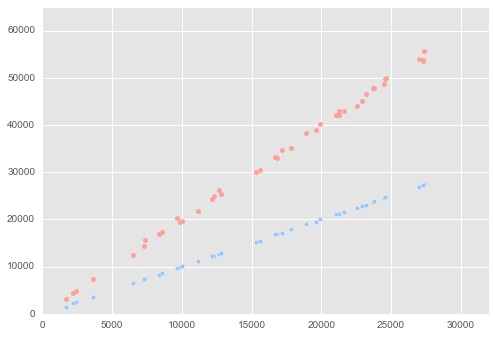

In [8]:
plt.scatter(input_hits1[:,2], src_hits1.base_PsfFlux_flux.values)
plt.scatter(input_hits1[:,2], src_hits1.base_PeakLikelihoodFlux_flux.values, color='r')
plt.xlim(0, 32000)
plt.ylim(0, 65000);

{'FP': 2, 'FN': 55, 'TP': 45}


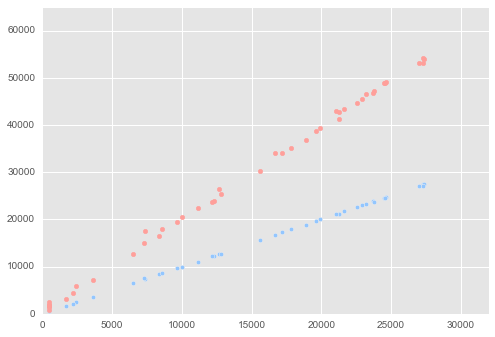

In [9]:
src = src2
dist = np.sqrt(np.add.outer(src.base_NaiveCentroid_x, -testObj.centroids[:, 0])**2. + \
   np.add.outer(src.base_NaiveCentroid_y, -testObj.centroids[:, 1])**2.) # in pixels
matches = np.where(dist <= 1.5)
true_pos = len(np.unique(matches[0]))
false_neg = testObj.centroids.shape[0] - len(np.unique(matches[1]))
false_pos = src.shape[0] - len(np.unique(matches[0]))
detections = {'TP': true_pos, 'FN': false_neg, 'FP': false_pos}
print detections

src_hits2 = src.iloc[matches[0],:]
input_hits2 = testObj.centroids[matches[1],:]

plt.scatter(input_hits2[:,3], src_hits2.base_PsfFlux_flux.values)
plt.scatter(input_hits2[:,3], src_hits2.base_PeakLikelihoodFlux_flux.values, color='r')
plt.xlim(0, 32000)
plt.ylim(0, 65000);

Plot input flux vs. measured SNR...

1661.57093842 14.2823323371
500.0 5.13521538067


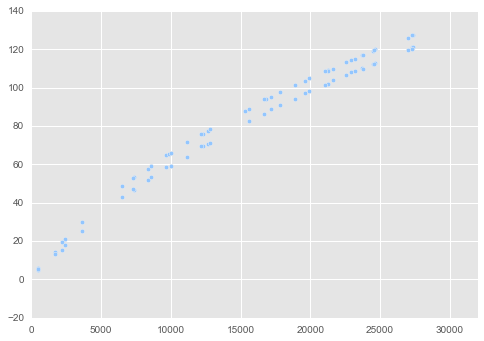

In [10]:
print input_hits1[:,2].min(), (src_hits1.base_PsfFlux_flux.values/src_hits1.base_PsfFlux_fluxSigma.values).min()
print input_hits2[:,3].min(), (src_hits2.base_PsfFlux_flux.values/src_hits2.base_PsfFlux_fluxSigma.values).min()
plt.scatter(input_hits1[:,3], src_hits1.base_PsfFlux_flux.values/src_hits1.base_PsfFlux_fluxSigma.values)
plt.scatter(input_hits2[:,3], src_hits2.base_PsfFlux_flux.values/src_hits2.base_PsfFlux_fluxSigma.values)
#plt.scatter(input_hits1[:,2], src_hits.base_PeakLikelihoodFlux_flux.values/src_hits.base_PeakLikelihoodFlux_fluxSigma.values, color='r')
plt.xlim(0, 32000);
#plt.ylim(0, 65000);

So a source with a SNR of ~500 corresponds to a flux of ~500 in the science image. So yes, it looks like we want to go down to as low as 500*sqrt(2) = 707 (flux) for new sources in the simulations to get about 5-sigma.